# training_Model_JetPretrain+ttbar.ipynb

This is code (in progress) for doing pre-training on jet selection

In [5]:
import sys
sys.path.append("/home/jchishol/TRecNet")
sys.path.append("home/jchishol/")

import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Masking, Reshape, TimeDistributed, Multiply #, Lambda, Activation
#from keras import backend as K
#from keras.utils.generic_utils import get_custom_objects
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb
from clr_callback import *
import importlib
from IPython.display import clear_output
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from training_utilities import PlotLearning

# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold

import normalize
import shape_timesteps
import analysis

## Load Files

In [6]:
# Data type we want to use
data_type = 'variables_ttbar_ljets_jetMatch04_6jets_train'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/ML_Data/'+data_type+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean_dic = np.load('../X_maxmean_'+data_type+'.npy',allow_pickle=True).item()
Y_maxmean_dic = np.load('../Y_maxmean_'+data_type+'.npy',allow_pickle=True).item()

## Useful Variables

In [7]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag','j2_pt', 'j2_eta', 'j2_phi', 'j2_m','j2_isbtag','j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['j1_isTruth','j2_isTruth','j3_isTruth','j4_isTruth','j5_isTruth','j6_isTruth','th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m','ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m']
#X_keys = list(filter(lambda a: 'isTruth' not in a and 'j' in a or 'lep' in a or 'met' in a, dataset.keys()))   # not in the order needed for Tao's code
#Y_keys = list(filter(lambda a: 'isTruth' in a or 'th' in a or 'tl' in a or 'wh' in a or 'wl' in a or 'ttbar' in a, dataset.keys()))
# VERY IMPORTANT THAT THESE ARE IN THE SAME ORDER AS THE MAXMEAN FILES

Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))
isTruth_keys = list(filter(lambda a: 'isTruth' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes (why?)

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
ymm_keys = list(Y_maxmean_dic.keys())
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(crop0)

5623632


## Scale the Data

In [8]:
# Scales data set to be between -1 and 1, with a mean of 0
importlib.reload(normalize)    # Need to reload so it recognizes the variables we just defined
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

In [9]:
# Also, for jet pretraining, we only want the truth values of the jets
Y_pretrain_total = Y_total[:,0:6]
Y_pretrain_names = Y_names[0:6]
Y_pretrain_maxmean = Y_maxmean[0:6]
print(Y_pretrain_names)

# And don't jet truth values later (at least the way things are set up now)
Y_total = Y_total[:,6:]
Y_names = Y_names[6:]
Y_maxmean = Y_maxmean[6:]
print(Y_names)

['j1_isTruth', 'j2_isTruth', 'j3_isTruth', 'j4_isTruth', 'j5_isTruth', 'j6_isTruth']
['th_ptbox', 'th_px', 'th_py', 'th_eta', 'th_m', 'wh_ptbox', 'wh_px', 'wh_py', 'wh_eta', 'wh_m', 'tl_ptbox', 'tl_px', 'tl_py', 'tl_eta', 'tl_m', 'wl_ptbox', 'wl_px', 'wl_py', 'wl_eta', 'wl_m', 'ttbar_ptbox', 'ttbar_px', 'ttbar_py', 'ttbar_eta', 'ttbar_m']


## Plot Scaled Inputs

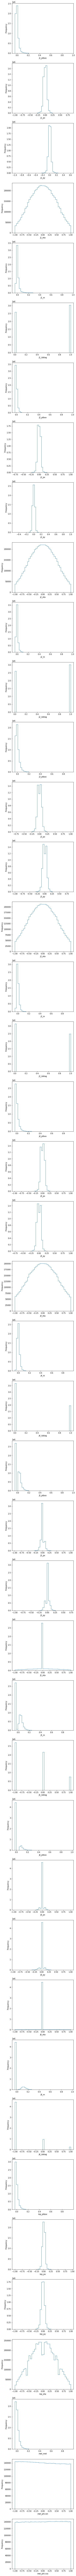

In [8]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

        #print("Min:",min(X_total[:,i]), " Max:",max(X_total[:,i]))

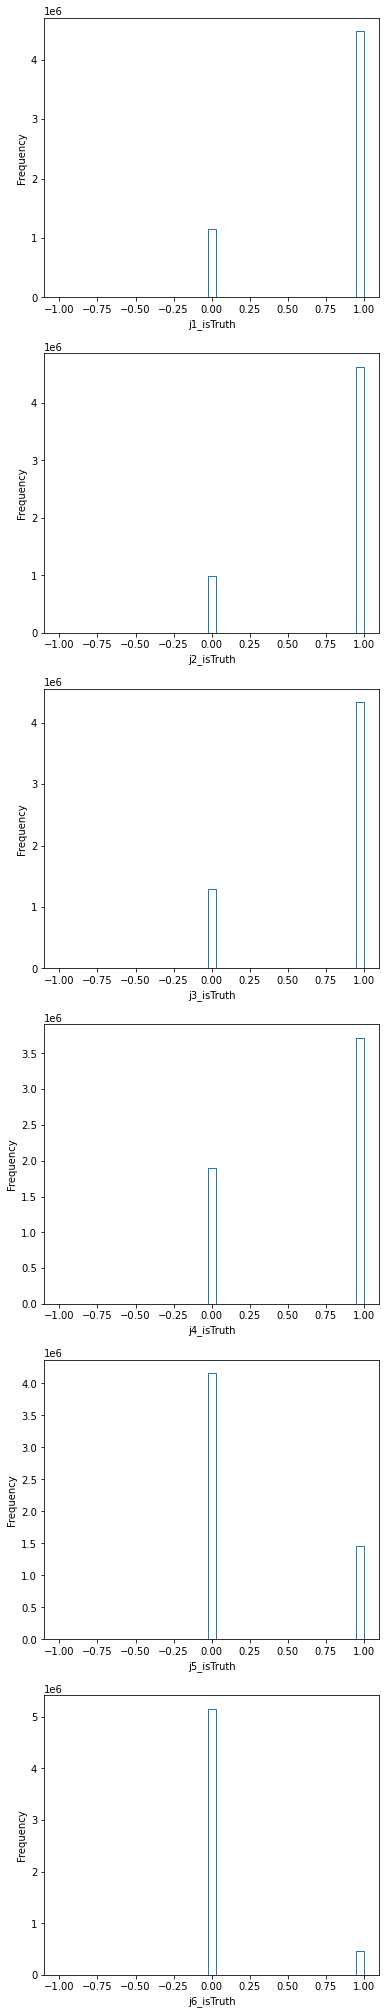

In [9]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
eta_bins = np.linspace(-1,1,40)
Y_bins = [eta_bins if 'eta' in name else phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_pretrain_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*Y_pretrain_total.shape[1]))
    for i in range(0, Y_pretrain_total.shape[1]):
        plt.subplot(Y_pretrain_total.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_pretrain_total[:,i], bins, histtype='step')
        plt.xlabel(Y_pretrain_names[i])
        plt.ylabel('Frequency')

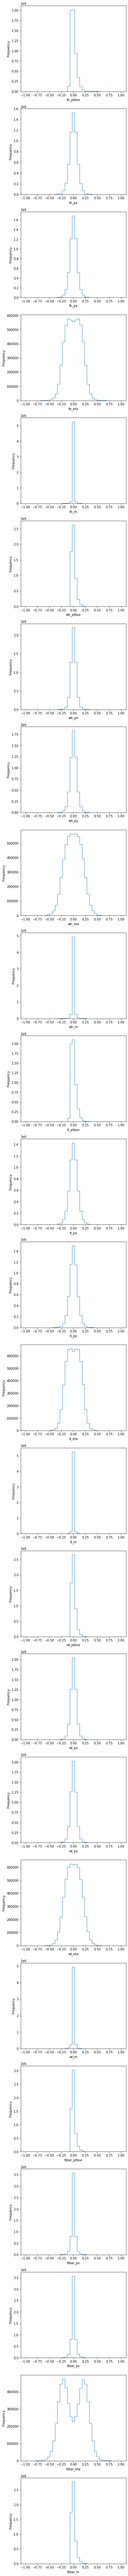

In [10]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*Y_total.shape[1]))
    for i in range(0, Y_total.shape[1]):
        plt.subplot(Y_total.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Split the Data

In [17]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
# Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation
split = 0.82

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training and validation data
trainX_jets, valX_jets, trainX_other, valX_other, trainY_pretrain, valY_pretrain, trainY, valY = train_test_split(totalX_jets, totalX_other, Y_pretrain_total, Y_total, train_size=split)

print(trainY.shape)

(4611378, 25)


## Build and Train Pre-Training Model

In [13]:
#def custom_activation(x):
#    return (K.sigmoid(x) * 5) - 1

#get_custom_objects().update({'custom_activation': Activation(custom_activation)})

#Heaviside (Unit Step) function with grad
# @tf.custom_gradient
# def heaviside(X):
#   List = []

#   for I in range(6):
#     Item = tf.cond(X[I]<0, lambda: tf.constant([0], tf.float32), lambda: tf.constant([1], tf.float32))
#     List.append(Item)

#   U = tf.stack(List)

#   #Heaviside half-maximum formula
#   #U = (tf.sign(X)+1)/2;

#   #Div is differentiation intermediate value
#   def grad(Div):
#     return Div*1; #Heaviside has no gradient, use 1.

#   return U,grad

# @tf.custom_gradient
# def binary_activation(x):

#     print(x)
#     print(tf.shape(x))
#     print(x.dtype.base_dtype)

#     ones = tf.ones(tf.shape(x), dtype=x.dtype.base_dtype)
#     zeros = tf.zeros(tf.shape(x), dtype=x.dtype.base_dtype)

#     def grad(dy):
#         return dy  # TODO define gradient
#     return keras.backend.switch(x > 0.5, ones, zeros), grad

#def custom_activation(x):
#    return (K.sigmoid(x) * 5) - 1



def build_pretrain_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]),name='jet_input')   # Input n jets, each with 6 variables (n,6)
    other_input = Input(shape=(trainX_other.shape[1]),name='other_input')       # Input other data
    flat_jets =  Flatten(name ='flattened_jets')(jet_input)                        # Flatten jet input to an array of length 6n
    concat0 = concatenate([other_input, flat_jets], name = 'flat_jets_other')          # Concatenate the other and jet data
    PreDense1 = Dense(256, activation='relu', name = 'dense256_1')(concat0)       # Input concatenated data to dense layer of 256 nodes
    PreDense2 = Dense(256, activation='relu', name = 'dense256_2')(PreDense1)     # Then to another dense layer of 256 nodes
    output = Dense(trainX_jets.shape[1],activation='sigmoid', name = 'jet_match_output')(PreDense2)    # Finally to a dense layer that outputs n numbers between 0 and 1
    #output = Lambda(lambda x: round(x))(PreOutput)
    #output = Lambda(lambda x: K.round(x)) (PreOutput)
    #output = custom_activation(PreOutput)

    # Optimization stuff (not really sure how this was chosen but okay)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-2, decay_steps=10000,end_learning_rate=5e-4,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Create and compile the model
    pretrain_model = keras.models.Model(inputs=[jet_input, other_input], outputs=output) 
    pretrain_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['mae','mse'])

    return pretrain_model


pretrain_model = build_pretrain_model()
pretrain_model.summary()
#keras.utils.plot_model(pretrain_model,to_file='Model_Jet_Pre-training.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 jet_input (InputLayer)         [(None, 6, 6)]       0           []                               
                                                                                                  
 other_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 flattened_jets (Flatten)       (None, 36)           0           ['jet_input[0][0]']              
                                                                                                  
 flat_jets_other (Concatenate)  (None, 43)           0           ['other_input[0][0]',            
                                                                  'flattened_jets[0][0]']     

2022-07-28 10:47:11.986001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-07-28 10:47:11.986039: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-28 10:47:11.986756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

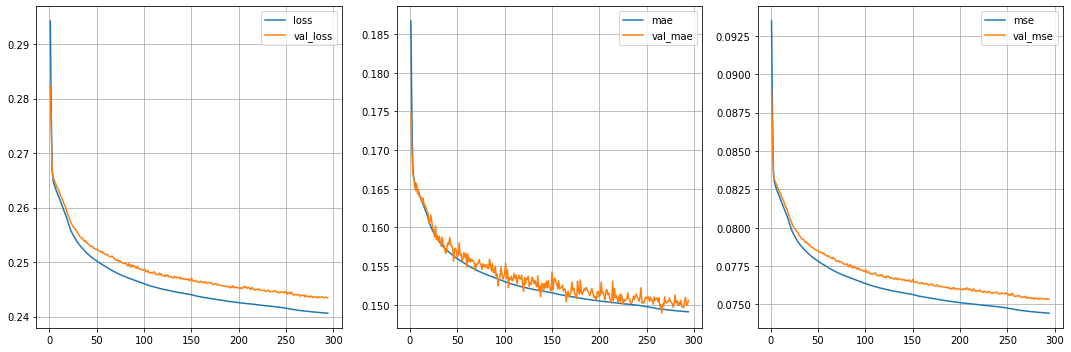

4612/4612 [==============================] - 26s 6ms/step - loss: 0.2406 - mae: 0.1491 - mse: 0.0744 - val_loss: 0.2435 - val_mae: 0.1506 - val_mse: 0.0753


In [14]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # patience=4 means stop training after 4 epochs with no improvement
#clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)   # not using I don't think?

# Set number of epochs (runs through?)
#Epochs= 256
Epochs = 500

## Fit the model (i.e. TRAIN the model)
history = pretrain_model.fit([trainX_jets, trainX_other], trainY_pretrain, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY_pretrain), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)



In [15]:
pretrain_model.save('Model_Jet_Pre-train.keras')
np.save('trainHistory_Model_Jet_Pre-train.npy',history.history)

In [11]:
pretrain_model = keras.models.load_model('Model_Jet_Pre-train.keras')
pretrain_history = np.load('trainHistory_Model_Jet_Pre-train.npy',allow_pickle='TRUE').item()

Text(0.5, 1.0, 'Jet Pre-train MSE Loss')

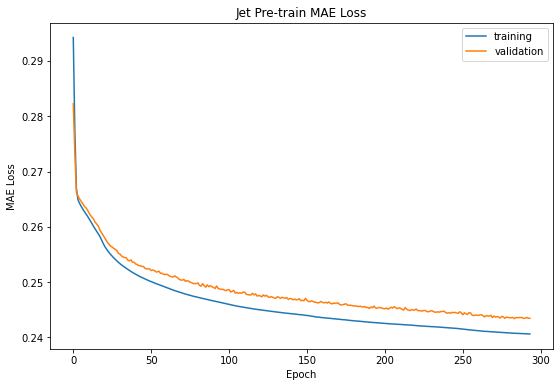

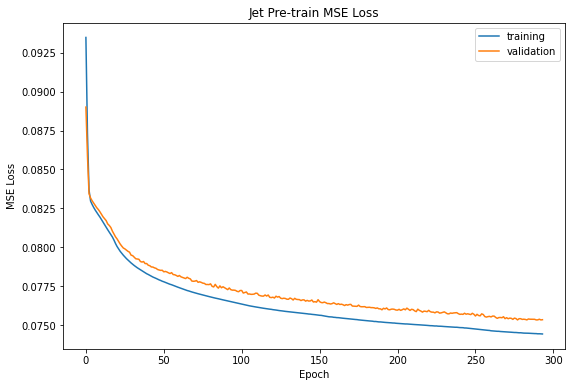

In [13]:
plt.figure(figsize=(9,6))
plt.plot(pretrain_history['loss'], label='training')
plt.plot(pretrain_history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.title('Jet Pre-train MAE Loss')

plt.figure(figsize=(9,6))
plt.plot(pretrain_history['mse'], label='training')
plt.plot(pretrain_history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Jet Pre-train MSE Loss')

In [16]:
#pretrain_model_old = keras.models.load_model('Model_Jet_Pre-train.keras')
predictions_unscaled = pretrain_model.predict([valX_jets, valX_other])
true_unscaled = valY_pretrain
y_round = predictions_unscaled.round()

/tmp/ipykernel_297118/3528854828.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


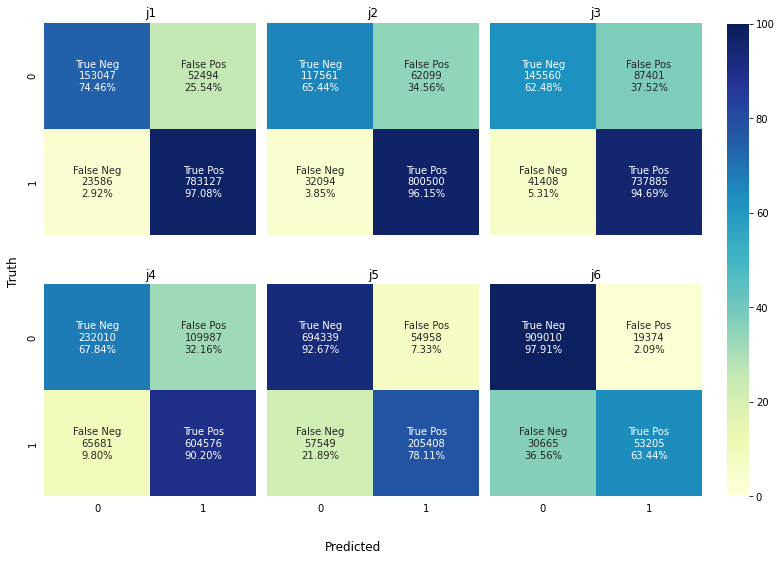

In [17]:
cms = multilabel_confusion_matrix(true_unscaled,predictions_unscaled.round())
#fig, axs = plt.subplots(2,3, sharex=True, sharey=True)

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10, 8))
cbar_ax = fig.add_axes([1.02, .11, .03, .82])


jet = 0
for i in range(2):
    for j in range(3):
        cm = cms[jet]
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm[0].flatten()/np.sum(cm[0])]
        group_percentages.extend(["{0:.2%}".format(value) for value in cm[1].flatten()/np.sum(cm[1])])
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        normed = [cm[0]*100/np.sum(cm[0]),cm[1]*100/np.sum(cm[1])]
        sub = sb.heatmap(normed,vmin=0, vmax=100, cmap='YlGnBu',fmt='',annot=labels, cbar_ax=cbar_ax,square=True, ax=ax[i,j])
        ax[i,j].set_title('j'+str(jet+1))
        ax[i,j].tick_params(left=False,bottom=False) 
        jet+=1



        #print('j'+str(jet+1)+' Accuracy: ',accuracy_score(true_unscaled[:,jet],predictions_unscaled.round()[:,jet]))
        #print('j'+str(jet+1)+' Precision: ',precision_score(true_unscaled[:,jet],predictions_unscaled.round()[:,jet]))


fig.supxlabel('Predicted')
fig.supylabel('Truth')

fig.tight_layout()



## Make Predictions with Jet Pretrain Model

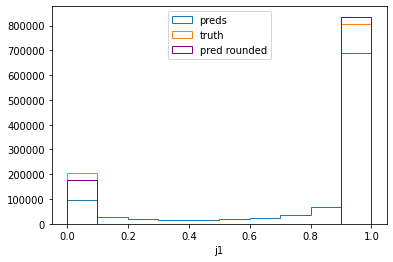

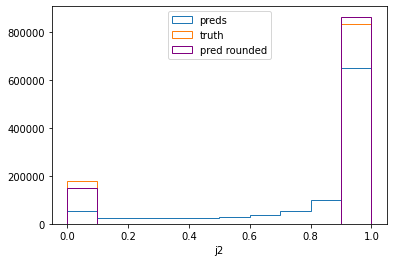

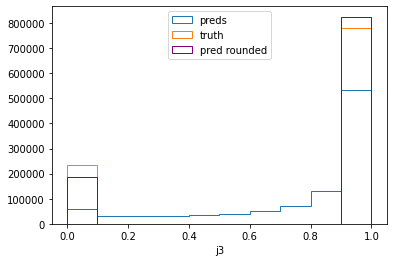

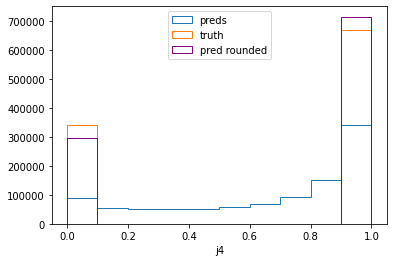

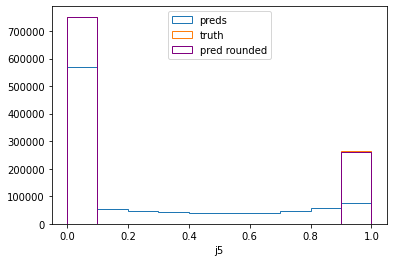

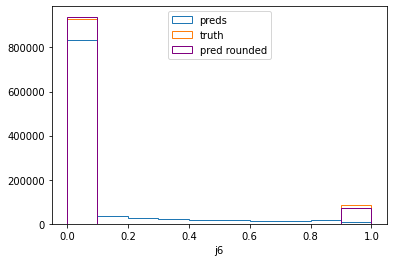

In [18]:
for i in range(6):
    plt.figure('j'+str(i+1))
    plt.hist(predictions_unscaled[:,i],bins=10,range=(0,1),histtype='step',label='preds')
    plt.hist(true_unscaled[:,i],bins=10,range=(0,1),histtype='step',label='truth')
    plt.hist(np.round(predictions_unscaled[:,i]),bins=10,range=(0,1),histtype='step',label='pred rounded',color='purple')
    plt.xlabel('j'+str(i+1))
    plt.legend(loc='upper center')

## Try Using These Weights in Overall Training

In [19]:
pretrain_model = keras.models.load_model('Model_Jet_Pre-train.keras')
print(pretrain_model.layers)
print(pretrain_model.summary())

[<keras.engine.input_layer.InputLayer object at 0x7fda3c943ac0>, <keras.engine.input_layer.InputLayer object at 0x7fda3c9432e0>, <keras.layers.core.flatten.Flatten object at 0x7fda547b6f10>, <keras.layers.merge.Concatenate object at 0x7fda3c96ca60>, <keras.layers.core.dense.Dense object at 0x7fda547b1490>, <keras.layers.core.dense.Dense object at 0x7fda547cb1f0>, <keras.layers.core.dense.Dense object at 0x7fda547bc4c0>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 jet_input (InputLayer)         [(None, 6, 6)]       0           []                               
                                                                                                  
 other_input (InputLayer)       [(None, 7)]          0           []                               
                                                                  

In [20]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    # flat_jets =  Flatten()(jet_input)
    # concat0 = concatenate([other_input, flat_jets])
    # PreDense1 = Dense(256, activation='relu')(concat0)
    # PreDense2 = Dense(256, activation='relu')(PreDense1)
    # PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    # Shape_Dot = Reshape((-1,1))(PreDense3)


    pretrain_model.trainable = False   # Freezing the jet pretrain model (i.e. want to use the previously trained weights)
    pretrain = pretrain_model([jet_input,other_input], training=False)  # Putting the inputs into the pretrain model
    
    
    Shape_Dot = Reshape((-1,1))(pretrain)

    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(10)(ldense2)   # 10 leptonic variable outputs
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(10+5)(hdense2)  # 10 hadronic variable outputs + 5 ttbar variable outputs
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)

    #model.get_layer(pretrain_model.layers[0].name).trainable = False
    #model.get_layer(pretrain_model.layers[1].name).trainable = False
    
    # Define loss function (do we even end up using this??)
    #def loss_fc(true, pred):
    #    return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
#keras.utils.plot_model(model,to_file='Model_Custom+ttbar.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 masking (Masking)              (None, 6, 6)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 reshape (Reshape)              (None, 6, 6)         0           ['masking[0][0]']                
                                                                                            

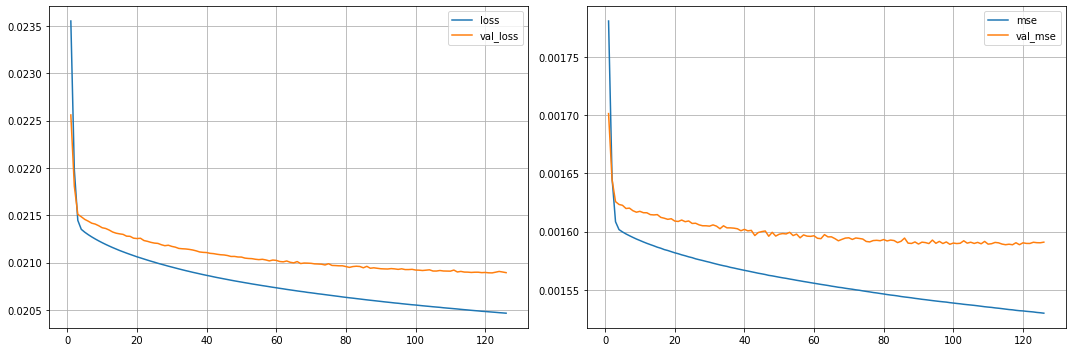

4612/4612 [==============================] - 73s 16ms/step - loss: 0.0205 - mse: 0.0015 - val_loss: 0.0209 - val_mse: 0.0016


In [23]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256
#Epochs=20

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

In [24]:
model.save('Model_JetPretrain+ttbar.keras')
np.save('trainHistory_Model_JetPretrain+ttbar.npy',history.history)

In [14]:
model = keras.models.load_model('Model_JetPretrain+ttbar.keras')
history = np.load('trainHistory_Model_JetPretrain+ttbar.npy',allow_pickle=True).item()

Text(0.5, 1.0, 'TRecNet_JetPretrain+ttbar MSE Loss')

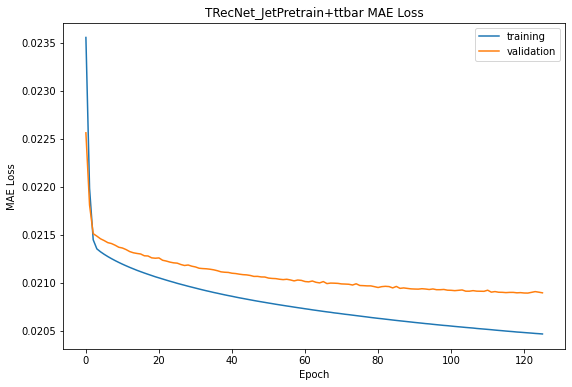

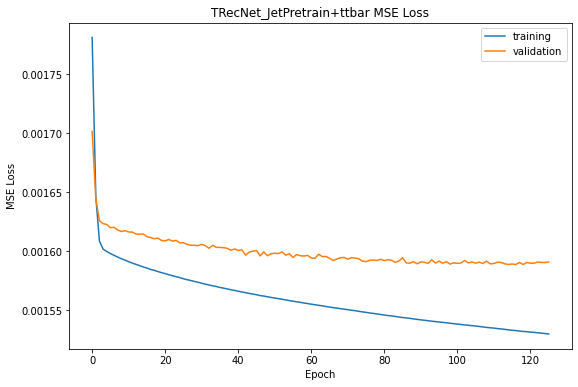

In [15]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.title('TRecNet_JetPretrain+ttbar MAE Loss')

plt.figure(figsize=(9,6))
plt.plot(history['mse'], label='training')
plt.plot(history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('TRecNet_JetPretrain+ttbar MSE Loss')

In [18]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

In [22]:
Analysis = analysis.Analysis

print(Y_keys[6:])

Analysis.display_errors(predictions_origscale, true_origscale, Y_keys[6:], True)
Analysis.save_errors(predictions_origscale,true_origscale,Y_keys[6:],True,'Model_Custom_JetPretrain+ttbar_Errors')

['th_pt', 'th_eta', 'th_phi', 'th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m', 'ttbar_pt', 'ttbar_eta', 'ttbar_phi', 'ttbar_m']
total MSE: 642.8234030554963
 
th_pt MSE, MAE :  1727.2738422140 28.1797358294
th_eta MSE, MAE :  0.4359881139 0.3656793009
th_phi MSE, MAE :  0.6444969314 0.4327612757
th_m MSE, MAE :  35.5275327180 2.1285223311
wh_pt MSE, MAE :  1310.2165229203 22.5203004275
wh_eta MSE, MAE :  0.5035392431 0.3907612507
wh_phi MSE, MAE :  0.6204664178 0.4347101809
wh_m MSE, MAE :  36.2152961366 2.6232650481
tl_pt MSE, MAE :  1210.8374141314 24.9928413159
tl_eta MSE, MAE :  0.2904176560 0.3540132652
tl_phi MSE, MAE :  0.3916786171 0.3258682446
tl_m MSE, MAE :  36.2506068520 2.1483575928
wl_pt MSE, MAE :  625.5221366795 18.2612063440
wl_eta MSE, MAE :  0.2848355922 0.3746711987
wl_phi MSE, MAE :  0.1852603953 0.2415858956
wl_m MSE, MAE :  36.9493082621 2.6596158255
ttbar_pt MSE, MAE :  1391.4468809554 24.4704